In [1]:
using Flux
using CUDA
using Flux: onehotbatch, argmax, crossentropy, throttle,onecold
using Flux: Data.DataLoader
using Base.Iterators: repeated
using Images
using Statistics
using MLDatasets

In [2]:
# Carregar dados MNIST
x_train, y_train = MNIST.(split=:train)[:]
x_test, y_test = MNIST.(split=:test)[:]


(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [3]:
x_train = Flux.unsqueeze(x_train, 3)
x_test = Flux.unsqueeze(x_test, 3)

size(x_train)

(28, 28, 1, 60000)

In [4]:
# Pré-processamento dos dados
#x_train = reshape(Flux.Float32.(x_train), 28, 28, 1, 60000)
#x_test = reshape(Flux.Float32.(x_test), 28, 28, 1, 10000)
y_train = onehotbatch(y_train, 0:9) 
y_test = onehotbatch(y_test, 0:9)

data_train = DataLoader((x_train, y_train), batchsize=128)

469-element DataLoader(::Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (28×28×1×128 Array{Float32, 4}, 10×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

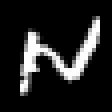

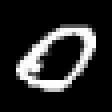

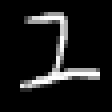

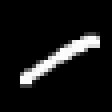

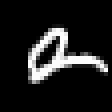

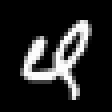

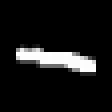

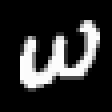

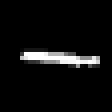

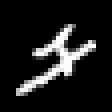

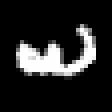

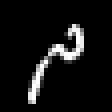

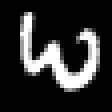

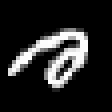

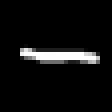

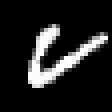

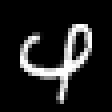

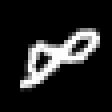

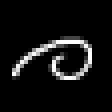

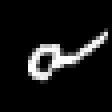

In [5]:
for i in 1:20
    img = reshape(x_train[:,:,:, i], 28, 28)
    image = Gray.(img)
    display(image)
end

In [15]:
model = Chain(
        # 28x28 => 14x14
        Conv((5, 5), 1 => 8, pad=2, stride=2, relu),
        # 14x14 => 7x7
        Conv((3, 3), 8 => 16, pad=1, stride=2, relu),
        # 7x7 => 4x4
        Conv((3, 3), 16 => 32, pad=1, stride=2, relu),
        # 4x4 => 2x2
        Conv((3, 3), 32 => 32, pad=1, stride=2, relu),

        # Average pooling
        GlobalMeanPool(),
        Flux.flatten,

        Dense(32, 10),
        softmax,
    )
loss(x,y) = Flux.crossentropy(model(x),y)
opt = ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [16]:
evalcb = () -> @show(loss(x_train, y_train))
parameters = Flux.params(model)
size(x_train)

(28, 28, 1, 60000)

In [ ]:
accuracy(y,ye) = mean(onecold(y) .== onecold(ye))

In [17]:
for i in 1:10
    Flux.train!(loss, parameters, data_train, opt)
    println("Epoch: $i:")
    @show(loss(x_train, y_train))
    @show(accuracy(model(x_train,y_train)))
end

loss(x_train, y_train) = 0.25515643f0
loss(x_train, y_train) = 0.15804149f0
loss(x_train, y_train) = 0.12274866f0
loss(x_train, y_train) = 0.1006379f0
loss(x_train, y_train) = 0.08575908f0
loss(x_train, y_train) = 0.07156449f0
loss(x_train, y_train) = 0.062623225f0
loss(x_train, y_train) = 0.055090614f0
loss(x_train, y_train) = 0.05219989f0
loss(x_train, y_train) = 0.050212238f0


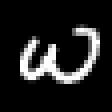

In [18]:
img = reshape(x_test[:,:,:, 91], 28, 28)
image = Gray.(img)
display(image)

In [32]:
y = model(reshape(x_test[:,:,:, 91], (size(x_test[:,:,:, 91])[1], size(x_test[:,:,:, 91])[2], 1, 1)))
pred = argmax(y)[1]-1
println("Predict to image 91 from Test dataset is $pred")

Predict to image 91 from Test dataset is 3


In [33]:
println("Accuracy: $(accuracy(model(x_test), y_test))")

Accuracy: 0.9764
